In [1]:
%matplotlib notebook
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import glob

sys.path.append("../../../libs/")
#import HEq
import MosaicFitsReader as mfr

In [43]:
from scipy import stats
from scipy.ndimage.filters import gaussian_filter

In [3]:
 def centroid(arr):
    """
    One step 1D centroiding algo.
    Returns centroid position and standard deviation
    """
    l = arr.shape[0]
    ixs = np.arange(l)
    arr = arr - np.median(arr)
    arr = np.where(arr < 0, 0, arr)    
    ixs2 = ixs * ixs
    sumarr = arr.sum()
    cen = np.dot(arr, ixs)/sumarr
    return cen, math.sqrt(np.dot(arr, ixs2)/sumarr - cen * cen)

def centroidLoop(arr, fromIdx, toIdx, nLoops=10, epsilon=1E-1):
    """
    Finds the centroid by repeatedly centering and recalculating 
    until the centroid position changes by less than epsilon.
    
    Returns status, centroid position, standard deviation, iterations
    
    status: 0 OK, -1 bad centroid or no signal
    centroid position: position relative to input array, ie. 0 is first pixel
    standard deviation: standard deviation as calculated by the centroid algorithm (assumed Gaussian stats)
    iterations: number of iterations needed until change is less than epsilon
    """
    def limit(x):
        if x < 0: return 0
        if x >= length: return length
        return x
    
    length = len(arr)
    radius = (toIdx - fromIdx)/2
    lastCenPos = -9999
    for i in range(nLoops):
        fromIdx = int(limit(fromIdx))
        toIdx = int(limit(fromIdx + radius + radius + 0.5))
        pos, cenStd = centroid(arr[fromIdx:toIdx])
        cenPos = pos + fromIdx
        #print (i, fromIdx, toIdx, cenPos, cenStd, lastCenPos)
        
        if cenPos < fromIdx or toIdx < cenPos:
            return -1, 0, 0, i
        
        if abs(lastCenPos - cenPos) < epsilon:
            return 0, cenPos, cenStd, i
        if cenStd > radius/3:
            return -1, cenPos, cenStd, i
        fromIdx = cenPos - radius
        lastCenPos = cenPos
        
    return -1, cenPos, cenStd, i  

In [4]:
def findWidths (arr1d, size=60):
    """
    Divides the input array in segments of size length.
    For each segment, finds the centroid, if centroid is good then record it.
    Sorts the centroids by standard deviation.
    Returns the smallest half of the standard deviation
    """
    out = []
    for x in range(0, len(arr1d)-size, size):
        ok, cen, std, idx = centroidLoop(arr1d, x, x+size)     
        #print (res)
        if ok == 0:
            out.append(std)
    #print (out)
    if len(out) <= 0:
        return []
    out = sorted(out)
    return out[:len(out)//2]

In [5]:
def makePairs(data):
    """
    Input data is in the format: ((focus1, (v1, v2, v3...)), (focus2, (v1, v2, v3)))
    
    Outputs the focus and std as pairs: ((focus1, v1), (focus1, v2), ....)
    """
    for a, b in data:
        for c in b:
            yield (a, c)
            
def calcAsymptote(A, B, C):
    """
    y^2 = Ax^2 + Bx + C
    
    Returns the parameters for the asymptotes for given A, B, C
    """
    h = -B/A/2
    a2 = C - A * h*h
    b2 = a2/A
    m0 = math.sqrt(a2/b2)
    b0 = -m0 * h
    return m0, b0, h

def asympFunc(m, b):
    """
    Returns a function to calculate the asymptote y for given x.
    """
    def f(x):
        return m * x + b
    return f

In [86]:
"""
Shui's version
For all input files, finds the standard deviations of the centroids.
These standard deviations are assosicated with the focus. 

Output is stored in out[].
"""
minrow = 200
maxrow = 3800
out = []
#for f in range(19, 26): #MOS MASK
#    fname = "test_images/mask/bfoc%04d.fits" % f

for f in range(8,15): #LongSlit blue
    fname = "test_images/longslit/bfoc%04d.fits" % f
    
#for f in range(1,7): #LongSlit red
#    fname = "test_images/longslit/rfoc%04d.fits" % f
    
    
    ffile = mfr.MosaicFitsReader(fname)
    img = np.array(ffile.data)
    blueFocus = ffile.getKeyword('BLUFOCUS')
    if blueFocus == None:
        continue
    for row in range(minrow,maxrow,100):
        cut1d = img[:,row]
        if np.max(gaussian_filter(cut1d,sigma=20))> 2000:
            widths = findWidths(cut1d)
            if len(widths)>5:
                clippedWidths,low,upp = stats.sigmaclip(widths,low=4,high=2)
                if clippedWidths.std()<1:
                    print(row,blueFocus,clippedWidths.mean(),low,upp,clippedWidths.std())
                    out.append((blueFocus, clippedWidths))


1500 -3717.99633789 3.68202320639 3.32861525194 3.85872718362 0.0883519886137
1600 -3717.99633789 3.7280299297 3.17265428203 4.00571775353 0.138843911917
1700 -3717.99633789 3.73757449844 3.18008967677 4.01631690927 0.139371205416
1800 -3717.99633789 3.71841596063 3.13225898559 4.01149444815 0.146539243761
1900 -3717.99633789 3.64675669556 3.10339686924 3.91843660872 0.13583995658
2000 -3717.99633789 3.65619281891 3.10088413652 3.9338471601 0.138827170597
2100 -3717.99633789 3.77544216737 2.96430822621 4.18100913795 0.202783485291
2200 -3717.99633789 3.79531196679 3.2010033665 4.09246626694 0.148577150074
2300 -3717.99633789 3.72438251646 3.23720837842 3.96796958547 0.121793534508
2400 -3717.99633789 3.68508631669 3.35171262189 3.8517731641 0.0833434237019
2500 -3717.99633789 3.71609068079 3.27489996997 3.9366860362 0.110297677705
2600 -3717.99633789 3.73592144412 3.37446496748 3.91664968244 0.0903641191607
1500 -3628.32397461 3.30476883809 2.87310818802 3.52059916313 0.107915162519
16

In [87]:
"""
Prepared values for display and for fitting
"""
pairs = np.array(list(makePairs(out))).T

In [88]:
"""
Fits a hyperbola: x=focus, y=standard deviation

Hyperbola equation: y^2 = Ax^2 + Bx + C

"""
res = np.polyfit(pairs[0], np.multiply(pairs[1], pairs[1]), deg=2)

func = np.poly1d(res)
def func1 (x):
    return math.sqrt(func(x))

funcV = np.vectorize(func1)

"""
Finds the parameters for the asymptotes
"""
A, B, C = res
m0, b0, minX = calcAsymptote(A, B, C)
print ("minX", minX, "Asymp", m0, b0)

minX -3507.96235742 Asymp 0.009669587717129308 33.9205497234


<IPython.core.display.Javascript object>


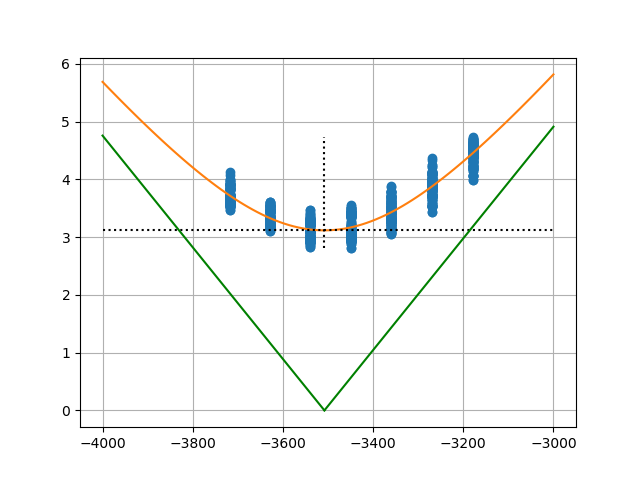

In [89]:
"""
Plots the (focus, std) pairs
"""
plt.plot(pairs[0], pairs[1], 'o')
x0, x1 = -4000, -3000 # min(pairs[0]), max(pairs[0])
#x0, x1 = -0.8,-0.5
"""
Plots the fitted hyperbola
"""
xs = np.linspace(x0, x1, 100)
plt.plot(xs, funcV(xs))

"""
Plots a vertical line at best focus and a horizontal line at best focus
"""
plt.plot((x0, x1), (funcV(minX), funcV(minX)), 'k:')
plt.plot((minX, minX), (min(pairs[1]), max(pairs[1])), 'k:')

"""
Plots the asymptotes
"""
posAsymp = asympFunc(m0, b0)
negAsymp = asympFunc(-m0, -b0)

plt.plot((x0, minX), (negAsymp(x0), negAsymp(minX)), 'g-')
plt.plot((minX, x1), (posAsymp(minX), posAsymp(x1)), 'g-')
plt.grid()